In [1]:
import numpy as np
import pandas as pd 
import kaggle as kaggle
import zipfile
import mlflow
import dagshub
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Download data, connect to dagshub
dagshub.init(repo_owner='egval20', repo_name='ml_Assignment1', mlflow=True)

mlflow.set_experiment('House Prices')
mlflow.set_tracking_uri('https://dagshub.com/egval20/ml_Assignment1.mlflow')

!kaggle competitions download -c house-prices-advanced-regression-techniques
with zipfile.ZipFile('house-prices-advanced-regression-techniques.zip', 'r') as zip_ref:
    zip_ref.extractall('.')


Accessing as egval20

Initialized MLflow to track repo "egval20/ml_Assignment1"

Repository egval20/ml_Assignment1 initialized!

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Import Data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## Data exploration

In [5]:
print(f"Train data shape: {train_data.shape}")

train_data.head()

Train data shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# data types
train_data.dtypes.value_counts()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# Missing values
train_missing_sum = train_data.isnull().sum()
train_missing_percent = (train_data.isnull().sum() / train_data.shape[0]) * 100

missing_data = pd.DataFrame({
    'Missing Count': train_missing_sum,
    'Missing Percent': train_missing_percent
})

missing = missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
missing

,Missing Count,Missing Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


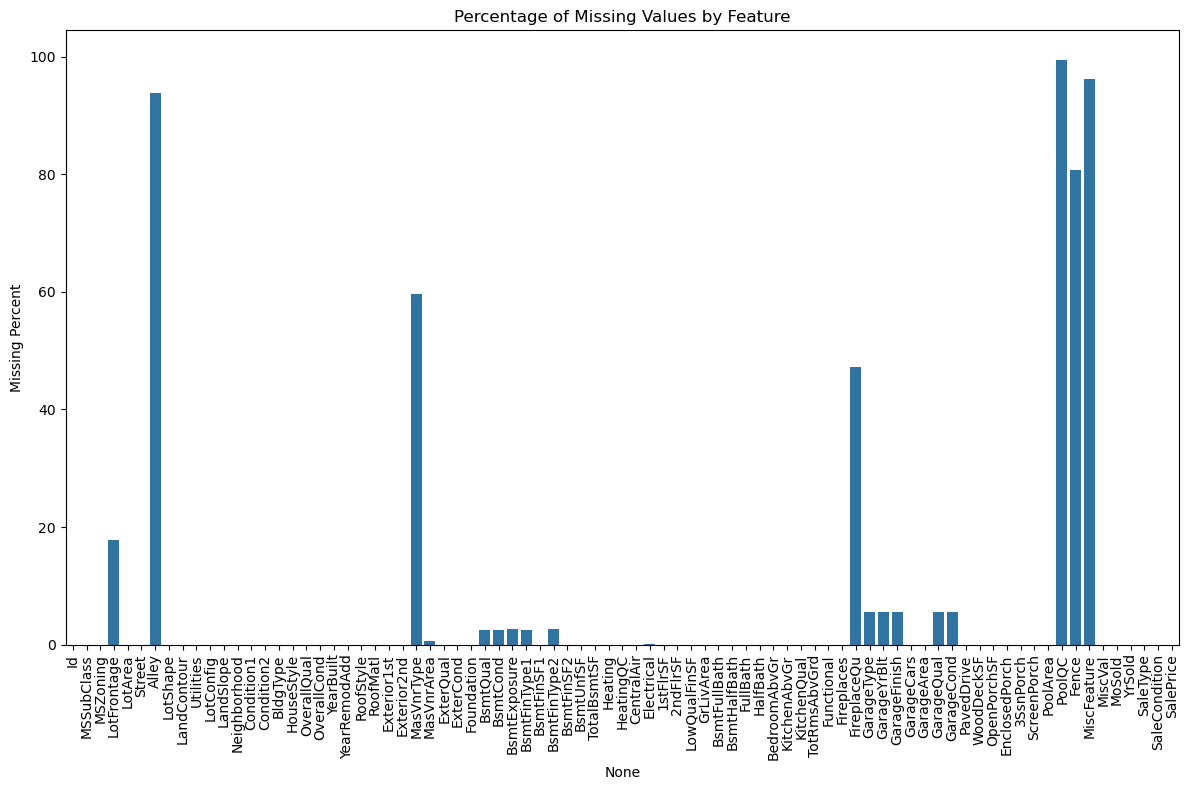

In [8]:
# Visualize missing values
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_data.index, y='Missing Percent', data=missing_data)
plt.xticks(rotation=90)
plt.title('Percentage of Missing Values by Feature')
plt.tight_layout()
plt.show()

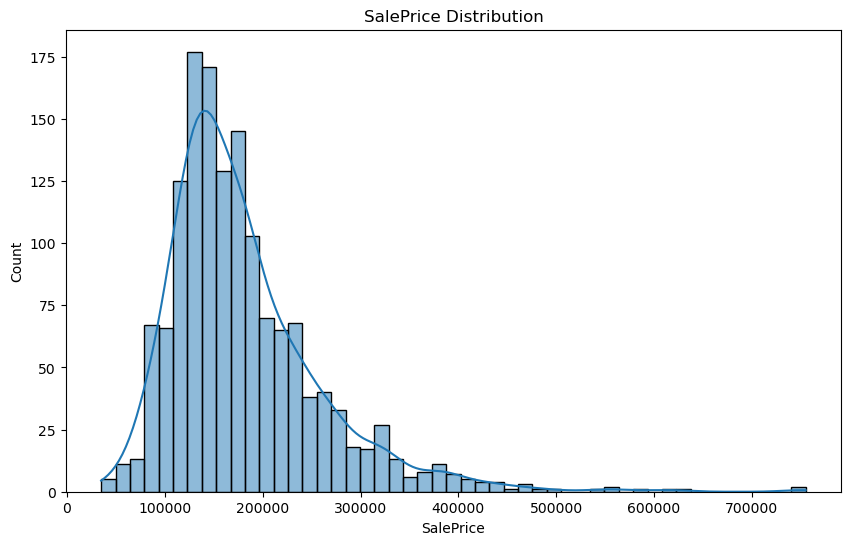

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [9]:
# target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.show()

train_data['SalePrice'].describe()

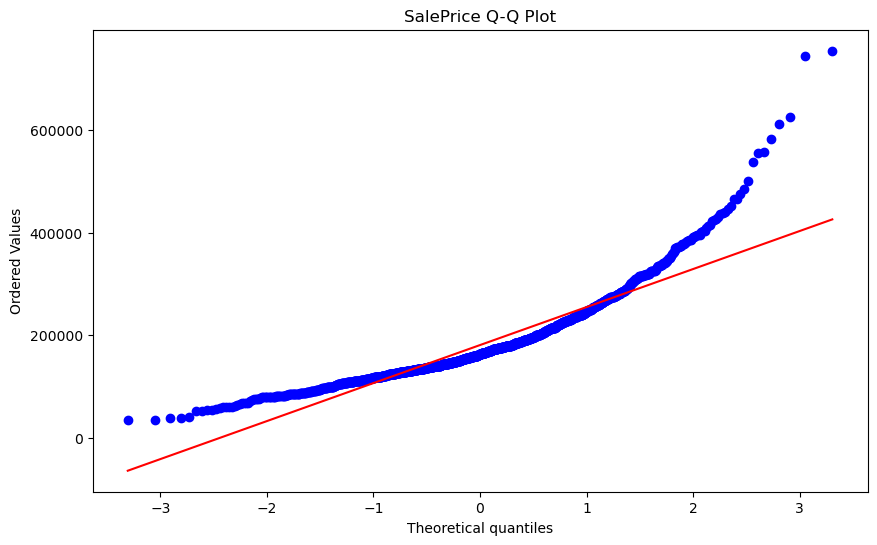

In [10]:
plt.figure(figsize=(10, 6))
stats.probplot(train_data['SalePrice'], plot=plt)
plt.title('SalePrice Q-Q Plot')
plt.show()

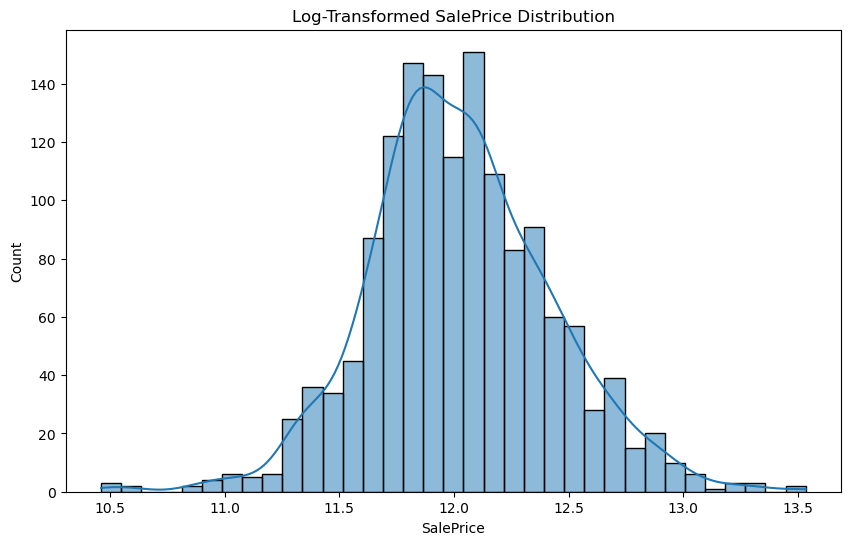

0.12134661989685333


In [11]:
if train_data['SalePrice'].skew() > 0.5:
    plt.figure(figsize=(10, 6))
    sns.histplot(np.log1p(train_data['SalePrice']), kde=True)
    plt.title('Log-Transformed SalePrice Distribution')
    plt.show()
    
    print(np.log1p(train_data['SalePrice']).skew())

In [12]:
# Numerical Features 
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).drop(['Id', 'SalePrice'], axis=1)
numeric_features.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [13]:
numeric_skewness = numeric_features.skew().sort_values(ascending=False)
numeric_skewness.head(10)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
dtype: float64

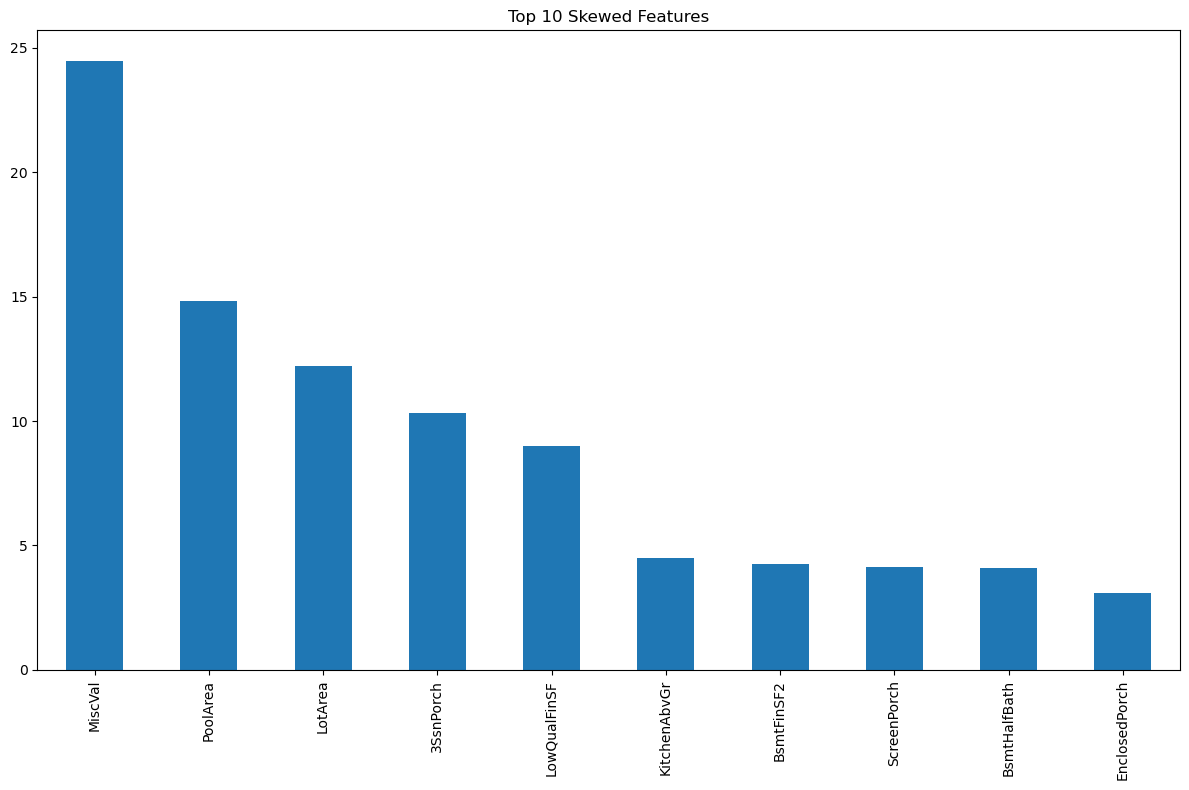

In [14]:
plt.figure(figsize=(12, 8))
numeric_skewness.head(10).plot(kind='bar')
plt.title('Top 10 Skewed Features')
plt.tight_layout()
plt.show()

In [15]:
# Correlation w numeric columns
numeric_data = train_data.select_dtypes(include=['int64', 'float64'])
correlations = numeric_data.corr()['SalePrice'].sort_values(ascending=False)
correlations.head(15)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

In [16]:
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()

categorical_features

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [17]:
categorical_cardinality = {col: train_data[col].nunique() for col in categorical_features}
categorical_cardinality = {k: v for k, v in sorted(categorical_cardinality.items(), key=lambda item: item[1], reverse=True)}

print('Unique Values Count \n')
for feature, cardinality in categorical_cardinality.items():
    print(f"{feature}: {cardinality}")

Unique Values Count 

Neighborhood: 25
Exterior2nd: 16
Exterior1st: 15
Condition1: 9
SaleType: 9
Condition2: 8
HouseStyle: 8
RoofMatl: 8
Functional: 7
RoofStyle: 6
Foundation: 6
BsmtFinType1: 6
BsmtFinType2: 6
Heating: 6
GarageType: 6
SaleCondition: 6
MSZoning: 5
LotConfig: 5
BldgType: 5
ExterCond: 5
HeatingQC: 5
Electrical: 5
FireplaceQu: 5
GarageQual: 5
GarageCond: 5
LotShape: 4
LandContour: 4
ExterQual: 4
BsmtQual: 4
BsmtCond: 4
BsmtExposure: 4
KitchenQual: 4
Fence: 4
MiscFeature: 4
LandSlope: 3
MasVnrType: 3
GarageFinish: 3
PavedDrive: 3
PoolQC: 3
Street: 2
Alley: 2
Utilities: 2
CentralAir: 2


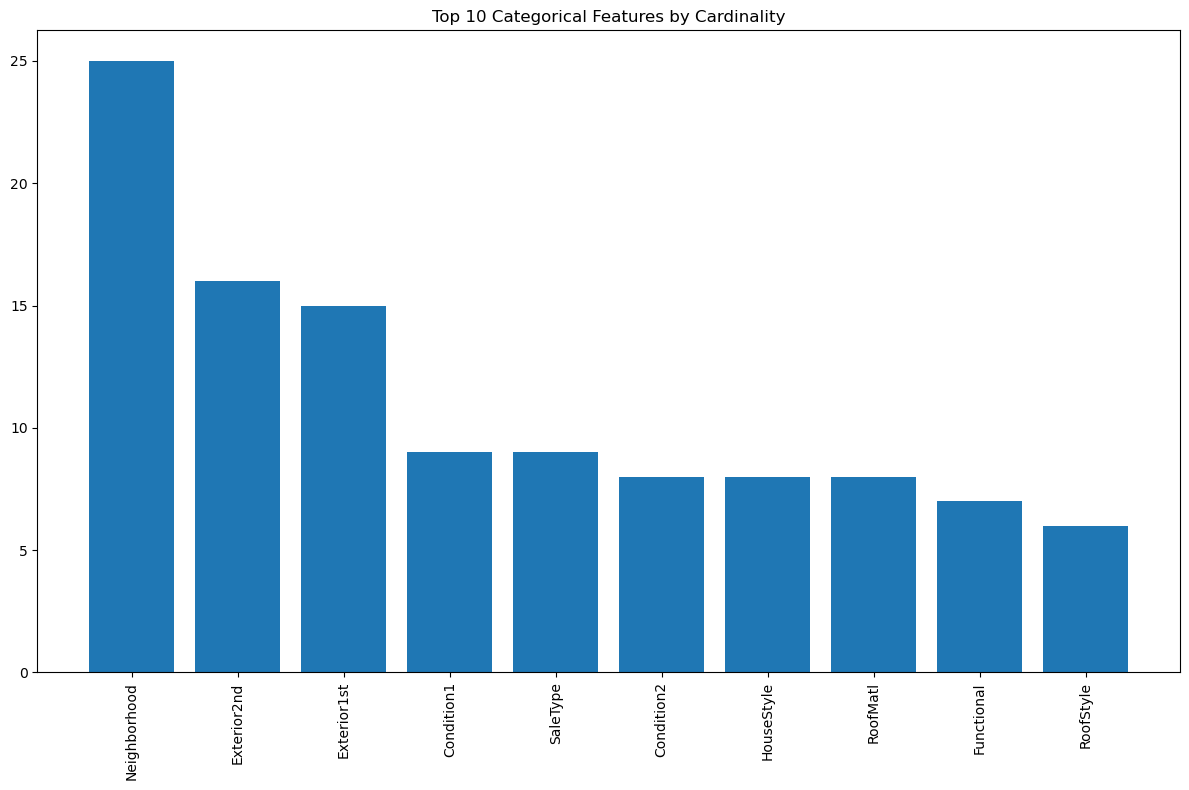

In [18]:
plt.figure(figsize=(12, 8))
top_categorical = dict(list(categorical_cardinality.items())[:10])
plt.bar(top_categorical.keys(), top_categorical.values())
plt.xticks(rotation=90)
plt.title('Top 10 Categorical Features by Cardinality')
plt.tight_layout()
plt.show()

In [19]:
for feature in list(categorical_cardinality.keys())[:5]:
    print(train_data[feature].value_counts().head())
    print('\n')

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Name: count, dtype: int64


Exterior2nd
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
Name: count, dtype: int64


Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
Name: count, dtype: int64


Condition1
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
Name: count, dtype: int64


SaleType
WD       1267
New       122
COD        43
ConLD       9
ConLI       5
Name: count, dtype: int64




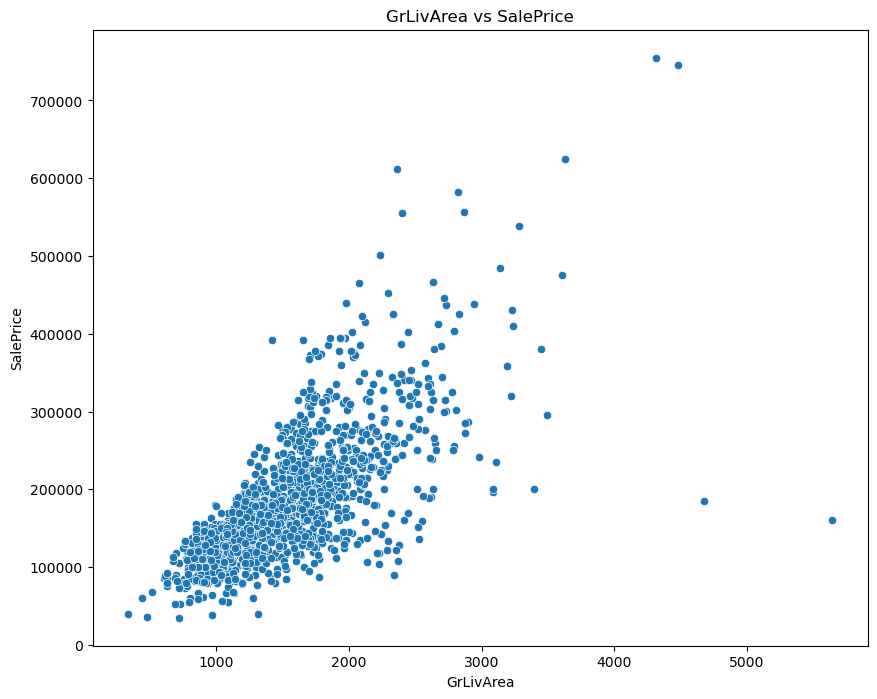

In [20]:
# Special Feature Analysis
plt.figure(figsize=(10, 8))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)
plt.title('GrLivArea vs SalePrice')
plt.show()

In [21]:
gr_liv_area_outliers = train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)]
gr_liv_area_outliers

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


Log All Data

In [23]:
with mlflow.start_run(run_name="data_exploration"):
    train_rows, train_cols = train_data.shape
    test_rows, test_cols = test_data.shape
    mlflow.log_param("train_rows", train_rows)
    mlflow.log_param("train_columns", train_cols)
    mlflow.log_param("test_rows", test_rows)
    mlflow.log_param("test_columns", test_cols)

    mlflow.log_param("total_missing_fields", len(missing_data))
    mlflow.log_param("max_missing_percent", missing_data['Missing Percent'].max())
    high_missing = missing_data[missing_data['Missing Percent'] > 15].index.tolist()
    mlflow.log_param("high_missing_features", str(high_missing))

    mlflow.log_metric("target_mean", train_data['SalePrice'].mean())
    mlflow.log_metric("target_median", train_data['SalePrice'].median())
    mlflow.log_metric("target_min", train_data['SalePrice'].min())
    mlflow.log_metric("target_max", train_data['SalePrice'].max())
    mlflow.log_metric("target_std", train_data['SalePrice'].std())
    mlflow.log_metric("target_skewness", train_data['SalePrice'].skew())

    mlflow.log_param("categorical_features_count", len(categorical_features))

    mlflow.log_param("potential_outliers_count", len(gr_liv_area_outliers))


🏃 View run data_exploration at: https://dagshub.com/egval20/ml_Assignment1.mlflow/#/experiments/0/runs/d06e42809e24422d8a9c0edffca47e85
🧪 View experiment at: https://dagshub.com/egval20/ml_Assignment1.mlflow/#/experiments/0
